In [1]:
import celmech as cm
import rebound as rb
import numpy as np
from celmech.poisson_series import PSTerm, PoissonSeries
from celmech.disturbing_function import df_coefficient_C,evaluate_df_coefficient_dict
from test_particle_secular_hamiltonian import calc_g0_and_s0, SyntheticSecularTheory
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from matplotlib import pyplot as plt

In [2]:
sim = rb.Simulation()
mtp = 0
sim.add(m = 1)
sim.add(m=1e-4,a=1)
sim.add(m=1e-4,a=10)
ss_theory = SyntheticSecularTheory([p.m for p in sim.particles[1:]],[p.a for p in sim.particles[1:]],[],[],[])
sma_list = np.linspace(2.3,5)
w0 = np.zeros((sma_list.size,2))
for i,a_tp in enumerate(sma_list):
    w0[i]=calc_g0_and_s0(a_tp,ss_theory)

sim.N_active = sim.N
for a in sma_list[::5]:
    sim.add(m=mtp,a = a,e=0.005,inc=0.01,pomega='uniform',Omega='uniform')
sim.integrator = 'whfast'
sim.ri_whfast.safe_mode = 0
sim.dt = np.min([p.P for p in sim.particles[1:]]) / 25.

Tfin_approx =2e7
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 512
try: 
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("tps_integrate.sa",coordinates='heliocentric')
except:
    sim.save_to_file("tps_integrate.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
    sim.integrate(Tfin,exact_finish_time=0)
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("tps_integrate.sa",coordinates='heliocentric')

/Users/hadden/miniconda3/envs/celmech/lib/python3.13/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


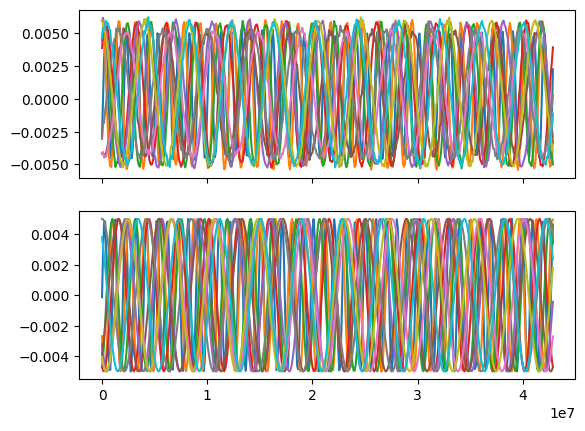

In [3]:
T = results['time']
results['z'] = results['e'] * np.exp(1j * results['pomega'])
results['zeta'] = np.sin(0.5*results['inc']) * np.exp(1j * results['Omega'])
gs = np.zeros((np.sum([p.m==0 for p in sim.particles]),4))
ss = np.zeros((np.sum([p.m==0 for p in sim.particles]),4))
l = 0
fig,ax=plt.subplots(2,1,sharex=True)
for i in np.where([p.m==0 for p in sim.particles[1:]])[0]:
    z_i = results['z'][i]
    zeta_i = results['zeta'][i]
    ax[0].plot(T,np.real(z_i))
    ax[1].plot(T,np.real(zeta_i))
    gs[l] = np.array(list(fmft(T,z_i,4).keys()),dtype=float)
    ss[l] = np.array(list(fmft(T,zeta_i,4).keys()),dtype=float)
    l+=1

In [4]:
import numpy as np

def closest_per_row(gs, targets):
    """
    For each row in `gs`, return the value closest to the corresponding value in `targets`.

    Parameters:
    gs (np.ndarray): A 2D array of shape (n, m), each row is a 1D array to search.
    targets (np.ndarray): A 1D array of shape (n,), each value is the target for the corresponding row.

    Returns:
    np.ndarray: A 1D array of shape (n,), each entry is the closest value in the corresponding row of `gs`.
    """
    # Compute absolute differences between each element and its row-specific target
    diffs = np.abs(gs - targets[:, np.newaxis])  # shape (n, m)
    
    # Indices of the closest values in each row
    idx = np.argmin(diffs, axis=1)
    
    # Extract the closest values using advanced indexing
    result = gs[np.arange(gs.shape[0]), idx]
    
    return result


Text(0.5, 0, 'Semi-major axis')

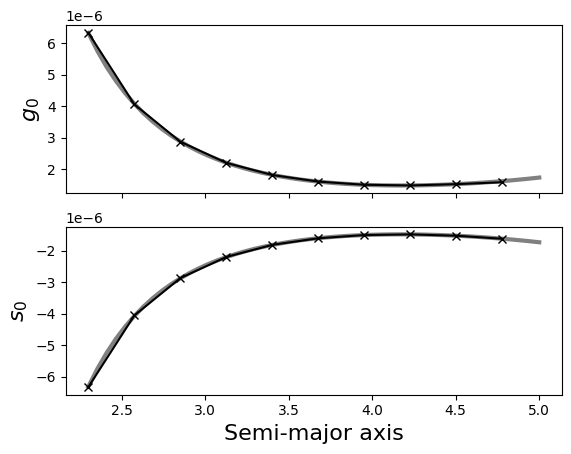

In [5]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(sma_list,w0[:,0],lw=3,color='gray')
ax[0].plot(sma_list[::5],closest_per_row(gs,w0[::5,0]),'kx-')
ax[0].set_ylabel(r"$g_0$",fontsize=16)
ax[1].plot(sma_list,w0[:,1],lw=3,color='gray')
ax[1].plot(sma_list[::5],closest_per_row(ss,w0[::5,1]),'kx-')
ax[1].set_ylabel(r"$s_0$",fontsize=16)
ax[1].set_xlabel(r"Semi-major axis",fontsize=16)